<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/2_obtencion_preparacion_exploracion_datos/2_4_hipotesis_alpha_factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4. Generación de alpha factors por hipotesis

## 0. Clonado de repositorio, importación de librerías y carga del dataset

### Clonado de repositorio e importación de librerías

In [103]:
#Clonamos el repo
#LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

!git clone https://github.com/GUNAPILLCO/neural_profit.git

fatal: destination path 'neural_profit' already exists and is not an empty directory.


In [104]:
import sys

#Instalación de librería pandas_market_calendars
#!{sys.executable} -m pip install -q pandas_market_calendars
#print("Librería instalada: pandas_market_calendars")

# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

### Carga del dataset mnq_intraday_data

In [105]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    # Reordenar columnas: 'date', 'time_str', y luego el resto
    cols = ['date'] + [col for col in df.columns if col not in ['date']]

    df = df[cols]

    return df

In [77]:
mnq_intraday = load_df()

## 1. Introducción

Un alpha factor es como una hipótesis cuantitativa: propone que una cierta transformación de los datos (por ejemplo, un RSI bajo o un volumen inusualmente alto) podría anticipar un movimiento futuro del precio.

Entonces, antes de entrenar un modelo LSTM, XGBoost o cualquier otro, el alpha factor te ayuda a descubrir cuáles features tienen “potencial predictivo”

**¿Qué hace realmente?**

- Evalúa si una variable (feature) tiene relación estadística con el retorno futuro.
- Te filtra las señales útiles del ruido.
- Acelera la selección de features sin tener que probar todo con modelos complejos primero.

Por ejemplo:

- Calculás el momentum 10 y ves que cuando es alto, el retorno a 5 minutos tiende a ser positivo → ese factor tiene alpha.
- Calculás el RSI 14 y no ves ninguna relación → ese factor no tiene alpha (en ese timeframe).


El Information Coefficient (IC) mide la correlación entre el alpha factor y el retorno futuro:

- IC > 0: el factor predice correctamente la dirección del retorno.
- IC ≈ 0: el factor no tiene poder predictivo.
- IC < 0: el factor tiene un poder inverso (indica lo contrario al retorno real).

Recordemos que nuestro target es el retorno de la variables 'close' y lo evaluaremos en tres ventanas de tiempo: 5, 15 y 30 minutos.

In [78]:
def add_targets (df):
  df['target_return_5'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
  df['target_return_15'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
  df['target_return_30'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
  return df

## 2. Funciones para evaluar alpha factor

In [122]:
def reset_dataset():
  mnq_intraday = add_targets(load_df())
  return mnq_intraday

### 2.1. Función para evaluar alpha factor

In [79]:
def evaluar_alpha_factor(df: pd.DataFrame,
                         factor_generador_fn,
                         target_minutes=[5, 15, 30],
                         factor_prefix="factor") -> pd.DataFrame:
    """
    Evalúa el poder predictivo (IC promedio por día) de un alpha factor generado.

    Parámetros:
    - df: DataFrame con columnas 'date', 'close', 'volume'
    - factor_generador_fn: función que recibe el df y target_minutes y agrega las columnas del alpha factor
    - target_minutes: ventanas de tiempo para calcular retornos futuros
    - factor_prefix: prefijo común de las columnas del factor (ej. 'momentum_z_', 'reversal_score_', etc.)

    Retorna:
    - DataFrame con el IC promedio para cada ventana de tiempo
    """
    df = df.copy()

    '''Ya están calculados los retornos:
    # 1. Calcular retornos futuros (target)
    for N in target_minutes:
        df[f'target_return_{N}'] = df.groupby('date')['close'].transform(
            lambda x: np.log(x.shift(-N)) - np.log(x)
        )'''

    # 2. Aplicar la función que genera el alpha factor
    df = factor_generador_fn(df, target_minutes)

    # 3. Calcular IC por día para cada ventana
    ic_results = {}
    for N in target_minutes:
        factor_col = f'{factor_prefix}{N}'
        target_col = f'target_return_{N}'
        ic_series = df.dropna(subset=[factor_col, target_col]).groupby('date').apply(
            lambda x: x[factor_col].corr(x[target_col])
        )
        ic_results[f'IC_{N}'] = ic_series.mean()

    return pd.DataFrame.from_dict(ic_results, orient='index', columns=['Mean IC'])


### 2.2. Función para observar el comportamiento durante el día


In [80]:
def plot_ic_by_minute(df: pd.DataFrame,
                      factor_5: str,
                      factor_15: str,
                      factor_30: str,
                      target_prefix: str = 'target_return_',
                      date_col: str = 'date'):
    """
    Calcula y grafica el IC por minuto intradía para tres alpha factors,
    mostrando el eje X en formato horario (desde las 08:30 AM).
    """

    df = df.copy()
    df['minute_index'] = df.groupby(date_col).cumcount()

    def compute_ic_by_minute(factor_col, target_col):
        grouped = df[[factor_col, target_col, 'minute_index']].dropna()
        return grouped.groupby('minute_index').apply(lambda x: x[factor_col].corr(x[target_col]))

    # Calcular ICs por minuto
    ic_minute_5 = compute_ic_by_minute(factor_5, f'{target_prefix}5')
    ic_minute_15 = compute_ic_by_minute(factor_15, f'{target_prefix}15')
    ic_minute_30 = compute_ic_by_minute(factor_30, f'{target_prefix}30')

    # Generar etiquetas horarias cada 30 minutos
    xticks = np.arange(0, 451, 30)
    start_time = pd.to_datetime("08:00")
    time_labels = [(start_time + pd.Timedelta(minutes=i)).strftime("%H:%M") for i in xticks]

    # Graficar
    plt.figure(figsize=(15, 6))
    plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
    plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
    plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title('IC por Minuto del Día')
    plt.xlabel('Hora intradía (desde 08:00)')
    plt.ylabel('Information Coefficient (IC)')
    plt.xticks(ticks=xticks, labels=time_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ic_minute_5, ic_minute_15, ic_minute_30

In [81]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame,
                                 mode: str = 'worst',
                                 top_n: int = 30,
                                 market_open: str = "08:00") -> pd.DataFrame:
    """
    Analiza series de IC minuto a minuto para distintos alpha factors.
    Retorna el IC mínimo, IC máximo, y el promedio de los top_n peores o mejores ICs,
    indicando la hora exacta en la que ocurren los extremos.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)
    - mode: 'worst' para los peores ICs, 'best' para los mejores ICs
    - top_n: cantidad de valores extremos a promediar
    - market_open: hora de inicio del mercado en formato "HH:MM" (por defecto 08:30)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los ICs extremos
    """
    results = []
    base_time = pd.to_datetime(market_open)

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()

        if mode == 'worst':
            extreme_vals = series.nsmallest(top_n)
        elif mode == 'best':
            extreme_vals = series.nlargest(top_n)
        else:
            raise ValueError("El parámetro 'mode' debe ser 'worst' o 'best'.")

        extreme_mean = extreme_vals.mean()

        # IC mínimo y su hora
        min_ic = series.min()
        min_minute = series.idxmin()
        min_time = (base_time + pd.Timedelta(minutes=min_minute)).strftime("%H:%M")

        # IC máximo y su hora
        max_ic = series.max()
        max_minute = series.idxmax()
        max_time = (base_time + pd.Timedelta(minutes=max_minute)).strftime("%H:%M")

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Hora del IC mínimo': min_time,
            'IC máximo': max_ic,
            'Hora del IC máximo': max_time,
            f'Promedio de los {top_n} {"peores" if mode == "worst" else "mejores"} ICs': extreme_mean
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    sort_col = result_df.columns[-1]
    result_df = result_df.sort_values(sort_col, ascending=(mode == 'worst'))

    return result_df

## 3. Hipotesis 1: Continuación del Momentum Intradía

**"Si el precio ha subido de forma constante en los últimos N minutos, es probable que continúe subiendo en los próximos minutos."**
<br><br>
**Justificación técnica:** <br>
Basada en la idea de momentum. Los traders tienden a subirse a la ola cuando ven un movimiento fuerte, generando continuación.
<br><br>
**Alpha Factor sugerido:** <br>Se define un factor de momentum como la diferencia entre los logaritmos del precio de cierre actual y el precio de cierre hace `N` minutos:

$$
\text{momentum}_t^{(N)} = \log(\text{close}_t) - \log(\text{close}_{t-N})
$$

Este valor puede interpretarse como el retorno logarítmico acumulado en los últimos `N` minutos. Valores positivos indican tendencia alcista reciente, mientras que valores negativos reflejan presión bajista.

**Parámetros recomendados para N:**  
- Corto plazo: `N = 5`
- Medio plazo: `N = 15`
- Largo plazo intradía: `N = 30`

**Aplicación:**

Este factor puede utilizarse como variable predictora en modelos supervisados, o directamente para generar señales de trading (ej: entrar en largo cuando Momentum > 0).

In [82]:
#Resetamos el dataset
reset_dataset()

In [83]:
#Hipotesis 1
def generar_momentum_z(df, ventanas):
    for N in ventanas:
        col_raw = f'momentum_{N}'
        col_z = f'momentum_z_{N}'
        df[col_raw] = df.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(N)))
        df[col_z] = df.groupby('date')[col_raw].transform(lambda x: (x - x.mean()) / x.std())
    return df

In [84]:
mnq_intraday = generar_momentum_z (mnq_intraday, [5, 15, 30])
IC_hip1 = evaluar_alpha_factor(mnq_intraday, generar_momentum_z, factor_prefix="momentum_z_")

In [85]:
IC_hip1

,Mean IC
IC_5,-0.025171
IC_15,-0.049925
IC_30,-0.099064


#### Análisis de resultados


1. La hipótesis 1 original no se valida.

    - El IC es negativo en todas las ventanas, lo que contradice la idea de "continuación de la tendencia".
    - De hecho: A mayor ventana (N), más negativo se vuelve el IC, lo que indica una mayor probabilidad de reversión cuando el momentum es fuerte.

2. Se sugiere comportamiento de Mean Reversion.

    - Este patrón es típico en mercados de alta frecuencia como MNQ, donde los movimientos rápidos suelen agotarse y dar paso a correcciones.
    - Cuanto más largo el período de momentum (30 minutos), más fuerte la señal de reversión.

### 3.1. Replanteto de Hipotesis 1:

Hipótesis alternativa: **Si el precio subió mucho en los últimos N minutos, es probable que revierta (baje).**

- Si el momentum ha sido muy alto (positivo), se espera una reversión bajista → señal negativa.
- Si ha sido muy bajo (negativo), se espera una reversión alcista → señal positiva.



In [86]:
#Resetamos el dataset
reset_dataset()

In [87]:
#Hipotesis 1 - Replanteo
def generar_rev_momentum_z(df, ventanas):
    for N in ventanas:
        col_raw = f'momentum_{N}'
        col_z = f'rev_momentum_z_{N}'
        df[col_raw] = df.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(N)))
        df[col_z] = df.groupby('date')[col_raw].transform(lambda x: - (x - x.mean()) / x.std())   #Signo invertido
    return df

In [88]:
mnq_intraday = generar_rev_momentum_z (mnq_intraday, [5, 15, 30])
IC_hip1_rev = evaluar_alpha_factor(mnq_intraday, generar_momentum_z, factor_prefix="rev_momentum_z_")

In [89]:
IC_hip1_rev

,Mean IC
IC_5,0.025171
IC_15,0.049925
IC_30,0.099064


#### Análisis de resultados


Al invertir el signo del factor de momentum, el alpha factor pasa de ser negativo a positivo.

Esto valida la hipótesis alternativa: **Los movimientos de precio recientes tienden a revertir, no a continuar.**

**Conclusión final:**
- Hipótesis 1 original (continuación del momentum) no se valida.
- Se valida la hipótesis alternativa: reversión del momentum intradía.

### 3.2. Comportamiento de A.F. durante el día:

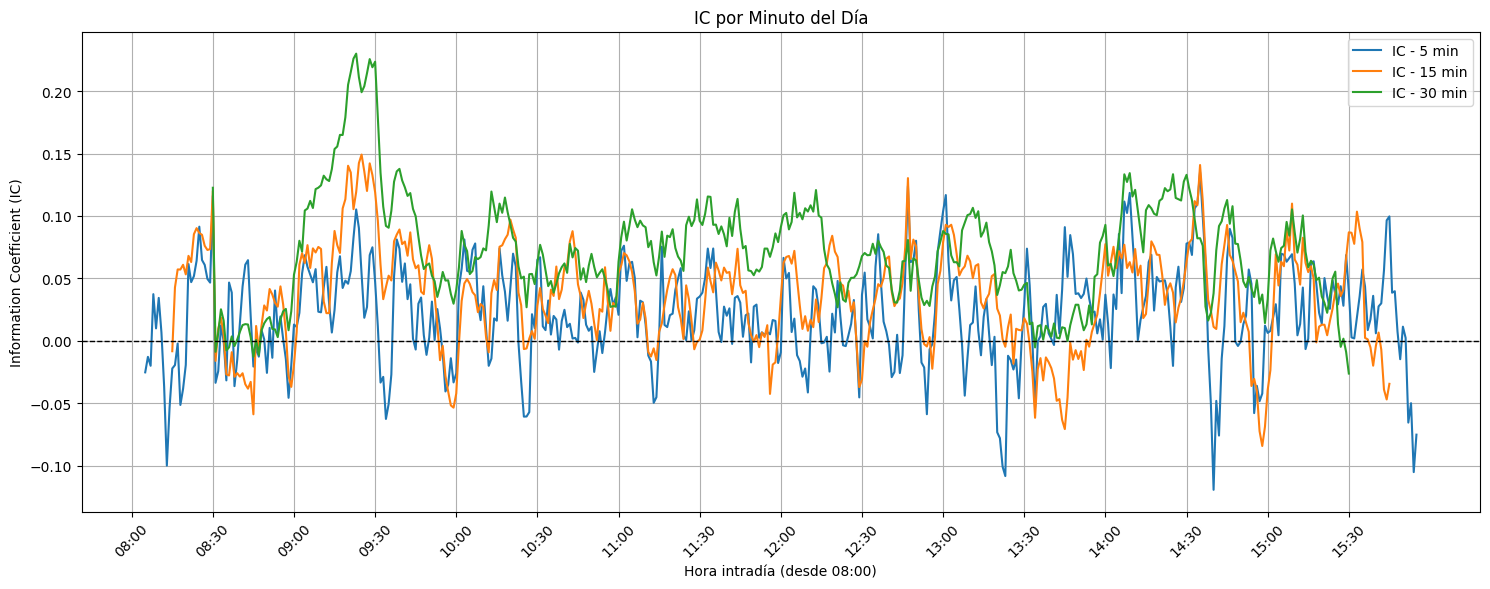

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 mejores ICs
Alpha Factor,,,,,
IC_rev_momentum_z_30,-0.026196,15:30,0.230023,09:23,0.169884
IC_rev_momentum_z_15,-0.084200,14:58,0.149193,09:25,0.114345
IC_rev_momentum_z_5,-0.119317,14:40,0.135223,14:35,0.096647


In [90]:
#Hipotesis 1
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='rev_momentum_z_5',
    factor_15='rev_momentum_z_15',
    factor_30='rev_momentum_z_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_rev_momentum_z_5': ic_minute_5,
    'IC_rev_momentum_z_15': ic_minute_15,
    'IC_rev_momentum_z_30': ic_minute_30
})

# Ver los mejores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='best', top_n=30)

El mejor alpha factor entre los tres evaluados es **`IC_rev_momentum_z_30`**, debido a que presenta:

- El **IC máximo más alto**: `0.23`
- El **promedio más alto de los 30 mejores ICs**: `0.1698`
- Su hora pico es en la apertura, lo cual coincide con zonas de alta volatilidad y reversión típica.
- Un **IC mínimo poco negativo**: `-0.026196`, lo que indica **bajo riesgo de señales contrarias**, sugiere que incluso en su peor momento, el factor no comete grandes errores.

Esto confirma empíricamente que una suba fuerte en 30 minutos suele anticipar una reversión bajista más efectiva que hacerlo con ventanas más cortas.

**Conclusión**: `momentum_rev_z_30` es el alpha factor más efectivo, estable y robusto para capturar patrones de **reversión intradía**.

### 3.3. Añadir `momentum_rev_z_30` al dataset:

In [91]:
#Recuerda que nuestro target es el retorno a 30 minutos.
# 2. Definimos el retorno futuro:
#mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
def add_reversion_momentum_factor(df: pd.DataFrame,
                          price_col: str = 'close',
                          date_col: str = 'date',
                          window: int = 30) -> pd.DataFrame:
    """
    Agrega una columna 'reversion_media_factor' que es el 'momentum_rev_z_30' al DataFrame, representando el alpha factor
    de reversión a la media basado en el z-score invertido de log-retornos a N minutos.

    Parámetros:
    - df: DataFrame de entrada con columnas de precios y fechas
    - price_col: nombre de la columna de precios (default='close')
    - date_col: nombre de la columna de fecha o jornada (default='date')
    - window: cantidad de minutos para calcular el momentum (default=30)

    Retorna:
    - DataFrame con la columna 'reversion_media_factor' añadida
    """
    df = df.copy()

    def calc_reversal(x):
        m = np.log(x) - np.log(x.shift(window))
        return -(m - m.mean()) / m.std()

    df['reversal_momentum_factor'] = df.groupby(date_col)[price_col].transform(calc_reversal)
    #df = df.dropna(subset=['momentum_rev_z_30'])

    return df

## 4. Hipotesis 2: Reversión a la Media (Mean Reversion)

**"Si el precio se aleja demasiado de su media móvil de corto plazo, tenderá a volver a ella."**
<br><br>
**Justificación técnica:**<br>
Alta frecuencia tiende a mostrar sobre-reacciones temporales. Este es un principio clásico del análisis técnico. En escalas de tiempo cortas, los precios tienden a oscilar alrededor de su media. Alejamientos extremos suelen generar correcciones rápidas, especialmente en activos líquidos como el MNQ.
<br><br>
**Alpha Factor sugerido:**
$$
\text{mean_reversion_factor}(t) = \frac{close(t) - \text{SMA}_N(t)}{\sigma_N(t)}
$$

Donde:
- $ \text{SMA}_N(t) $ es la media móvil simple de los últimos N minutos.
- ${\sigma_N(t)}$ es la desviación estándar en la misma ventana.


**El z-score te dice cuán lejos está un valor respecto a su promedio, medido en unidades de desviación estándar.**
<br>
Es una forma de medir si algo está “muy arriba” o “muy abajo” de lo normal.

In [92]:
#Resetamos el dataset
reset_dataset()

In [93]:
#Hipotesis 2
def generar_reversal_score(df, ventanas):
    for N in ventanas:
        sma = f'sma_{N}'
        std = f'std_{N}'
        z = f'zscore_{N}'
        rev = f'reversal_score_{N}'
        df[sma] = df.groupby('date')['close'].transform(lambda x: x.rolling(N, 1).mean())
        df[std] = df.groupby('date')['close'].transform(lambda x: x.rolling(N, 1).std())
        df[z] = (df['close'] - df[sma]) / df[std]
        df[rev] = df.groupby('date')[z].transform(lambda x: (x - x.mean()) / x.std())
    return df

In [94]:
mnq_intraday = generar_reversal_score (mnq_intraday, [5, 15, 30])

In [95]:
print('Para Z-Score:')
IC_hip2 = evaluar_alpha_factor(mnq_intraday, generar_reversal_score, factor_prefix="zscore_")

Para Z-Score:


In [96]:
print('Para Reversal Z-Score:')
IC_hip2_rev = evaluar_alpha_factor(mnq_intraday, generar_reversal_score, factor_prefix="reversal_score_")

Para Reversal Z-Score:


#### Análisis de resultados

El Information Coefficient (IC) entre el Reversal Z-Score y los retornos futuros es negativo y se incrementa en magnitud a medida que aumenta el horizonte temporal:

  - 0.0182 a 5 minutos → débil pero consistente
  - 0.0394 a 15 minutos → más marcado
  - 0.0698 a 30 minutos → efecto de reversión más claro

Esto indica que el factor tiene valor predictivo en contra de la dirección del desvío del precio, es decir, cuando el precio se aleja de su media, tiende a revertir.

Además, como el Reversal Z-Score mide qué tan extrema es la desviación del precio respecto a su media reciente, es razonable esperar que su poder predictivo sea mayor cuando su valor absoluto es alto (es decir, en situaciones de sobrecompra o sobreventa intradía).

Algunas conclusiones importantes:

1. La hipotesis 2 original se valida

  - La hipótesis 2 se valida parcialmente: los ICs negativos indican que cuando el precio está muy por encima de su media reciente (z-score alto), el retorno futuro tiende a ser negativo, lo que confirma un comportamiento de reversión a la media intradía.

  - Aunque la magnitud del IC no es muy alta, la dirección es consistente en todos los horizontes temporales, especialmente a 30 minutos. Esto sugiere que este alpha factor puede ser útil como entrada complementaria dentro de un modelo más complejo.

2. Reversión a la media intradía

  - Ambos factores muestran exactamente el mismo poder predictivo, lo cual era esperable ya que el Reversal Z-Score es simplemente una versión normalizada del Z-Score (y la correlación no cambia con transformaciones lineales).

  - Sin embargo, para entrenar un modelo de IA, voy a usar reversal_score_30, ya que está centrado y escalado por jornada, lo cual facilita el aprendizaje del modelo y mejora su capacidad de generalización.

### 4.1. Comportamiento de A.F. durante el día:

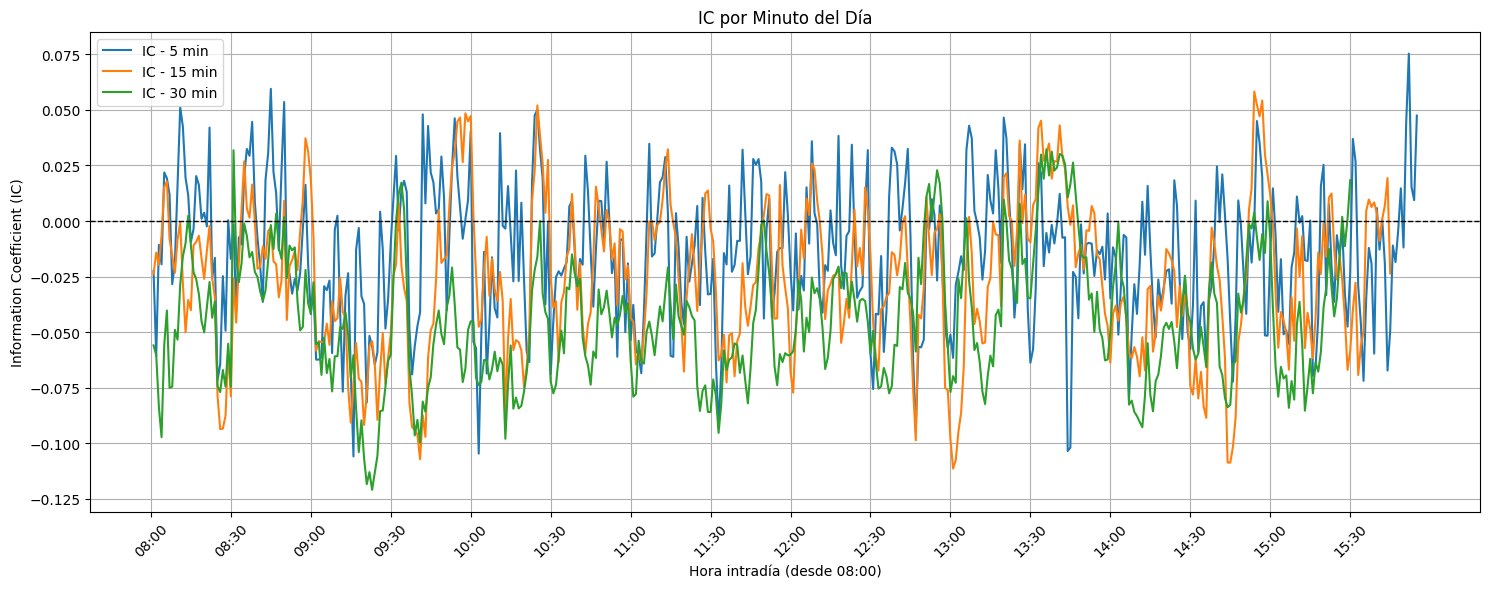

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
IC_rev_score_30,-0.120883,09:23,0.032287,13:36,-0.094196
IC_rev_score_15,-0.111339,13:01,0.058221,14:54,-0.092662
IC_rev_score_5,-0.105877,09:16,0.075271,15:52,-0.075124


In [97]:
#Hipotesis 2
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='reversal_score_5',
    factor_15='reversal_score_15',
    factor_30='reversal_score_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_rev_score_5': ic_minute_5,
    'IC_rev_score_15': ic_minute_15,
    'IC_rev_score_30': ic_minute_30
})

# Ver los peores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)

1. Los ICs más negativos se concentran en la apertura y primeras horas del día

  - El mínimo IC de reversal_score_30 es -0.121 a las 09:23, apenas pasada la apertura.
  - reversal_score_5 también alcanza su peor IC a las 09:16.
  
  Esto sugiere que la hipótesis de reversión puede fallar más en la apertura, donde hay más volatilidad e inestabilidad direccional.

2. Los mejores ICs (aunque bajos) aparecen en la tarde

  - reversal_score_30 alcanza su mejor valor positivo (0.0323) recién a las 13:36.
  - reversal_score_5 logra su pico positivo (0.0753) a las 15:52, cerca del cierre.
  
  Esto indica que la reversión a la media funciona mejor en las horas finales del día, posiblemente porque el mercado entra en rangos más definidos.

3. Los 30 peores ICs promedian un valor negativo fuerte
  
  Esto refuerza la validez de la hipótesis, ya que:
  - Aunque el promedio general del IC es bajo, el alpha factor muestra consistencia en producir señales opuestas al movimiento futuro (reversión) en los peores momentos del día.
  - El hecho de que el peor IC sea negativo en todos los casos, y que los promedios negativos sean más fuertes que los positivos, indica que la reversión tiene un efecto estadístico claro.

**Conclusión:**

Aunque el `reversal_score_N` tiene un desempeño débil al inicio de la jornada, igual voy a incluirlo como alpha factor en mi modelo de machine learning. La reversión a la media intradía es un fenómeno real, y este factor captura esa lógica con suficiente consistencia, especialmente a partir del mediodía.

Además, confío en que el modelo podrá aprender cuándo confiar y cuándo no en esta señal, en función de la hora del día y otras condiciones del mercado. Como el modelo puede capturar relaciones no lineales y condicionales, incluso un factor débil en ciertos tramos del día puede aportar valor predictivo cuando se combina con otras variables.

Por eso, el `reversal_score_30` será parte de las entradas de mi modelo IA para predicción intradía.

### 4.2.  Añadir `reversal_score_30` al dataset:

In [98]:
def add_reversal_media_factor(df: pd.DataFrame, window: int = 30, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega al DataFrame un alpha factor basado en la hipótesis 2 (reversión a la media),
    llamado 'reversal_score_{window}', calculado como z-score normalizado por jornada.

    No guarda columnas intermedias.

    Parámetros:
    - df: DataFrame con columnas 'date' y una columna de precios (por defecto 'close')
    - window: Ventana para el cálculo del z-score (en minutos)
    - price_col: Nombre de la columna de precios

    Retorna:
    - El DataFrame original con una nueva columna 'reversal_score_{window}'
    """
    z_col = f'_tmp_z_{window}'
    reversal_col = f'reversal_media_factor'

    # Calcular z-score por jornada
    df[z_col] = df.groupby('date')[price_col].transform(
        lambda x: (x - x.rolling(window=window, min_periods=1).mean()) /
                  x.rolling(window=window, min_periods=1).std()
    )

    # Normalizar el z-score por jornada
    df[reversal_col] = df.groupby('date')[z_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Eliminar columna temporal
    df.drop(columns=[z_col], inplace=True)

    return df

## 5. Hipotesis 3: Volumen como confirmación de dirección

**"Un movimiento alcista con aumento de volumen tiene más chances de continuar."**
<br><br>
**Justificación técnica:**<br>
Esta hipótesis está basada en un principio clásico del análisis técnico: el volumen confirma la tendencia. Si hay momentum y ese movimiento está respaldado por un volumen inusualmente alto, la probabilidad de que continúe el movimiento es mayor.
<br><br>
**Alpha Factor sugerido:**

$$
\text{Factor}_t = \text{Momentum}_t \times \left( \frac{\text{volume}_t}{\text{VolumenPromedio}_N} \right)
$$

Donde:  
- $\text{Momentum}_t$ es el retorno logarítmico del precio en los últimos $N$ minutos.  
- $\text{VolumenPromedio}_N$ es la media móvil del volumen en una ventana de $N$ minutos.

Usamos N = 5, 15 y 30 como en las hipotesis anteriores.


In [99]:
#Resetamos el dataset
reset_dataset()

In [100]:
#Hipotesis 3
def generar_momentum_vol_z(df, ventanas):
    for N in ventanas:
        mom = f'momentum_{N}'
        vavg = f'vol_avg_{N}'
        vr = f'vol_ratio_{N}'
        factor = f'mom_vol_{N}'
        z = f'mom_vol_z_{N}'
        df[mom] = df.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(N)))
        df[vavg] = df.groupby('date')['volume'].transform(lambda x: x.rolling(N, 1).mean())
        df[vr] = df['volume'] / df[vavg]
        df[factor] = df[mom] * df[vr]
        df[z] = df.groupby('date')[factor].transform(lambda x: (x - x.mean()) / x.std())
    return df

In [101]:
mnq_intraday = generar_momentum_vol_z (mnq_intraday, [5, 15, 30])
IC_hip3 = evaluar_alpha_factor(mnq_intraday, generar_momentum_vol_z, factor_prefix="mom_vol_z_")

In [102]:
IC_hip3

,Mean IC
IC_5,-0.024858
IC_15,-0.049027
IC_30,-0.086046


#### Análisis de resultados


1. Signo negativo:
    
    El hecho de que los IC sean negativos indica que el alpha factor está correlacionado inversamente con los retornos futuros. Es decir:

    - Cuando el precio sube con alto volumen, tiende a revertir en lugar de continuar.

    Esto contradice la hipótesis original que asume confirmación de dirección.

2. Magnitud creciente con la ventana:
    
    El efecto se vuelve más fuerte (más negativo) a medida que aumenta el horizonte de predicción. Esto sugiere que:
    
    - En el corto plazo (5 min) la señal es más débil (quizás ruido).
    - En horizontes mayores (15-30 min), el mercado tiende a corregir movimientos bruscos con alto volumen.

La hipótesis 3 no se valida: Estos valores de IC negativos indican que el factor `momentum × volumen relativo` tiende a anticipar movimientos contrarios al retorno futuro esperado, es decir, hay señales de reversión y no de continuación.

### 5.1. Replanteo de Hipotesis 3:

Hipótesis alternativa: **Cuando hay un gran movimiento de precio con alto volumen, la dirección tiende a revertirse.**

Esto convierte el alpha factor en un indicador de reversión en lugar de continuación.

In [ ]:
#Resetamos el dataset
reset_dataset()

In [109]:
#Hipotesis 3 - Replanteo
def generar_rev_momentum_vol_z(df, ventanas):
    for N in ventanas:
        mom = f'momentum_{N}'
        vavg = f'vol_avg_{N}'
        vr = f'vol_ratio_{N}'
        factor = f'mom_vol_{N}'
        z = f'rev_mom_vol_z_{N}'
        df[mom] = df.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(N)))
        df[vavg] = df.groupby('date')['volume'].transform(lambda x: x.rolling(N, 1).mean())
        df[vr] = df['volume'] / df[vavg]
        df[factor] = df[mom] * df[vr]
        df[z] = df.groupby('date')[factor].transform(lambda x: -(x - x.mean()) / x.std()) #Signo invertido
    return df

In [110]:
mnq_intraday = generar_rev_momentum_vol_z (mnq_intraday, [5, 15, 30])
IC_hip3_rev = evaluar_alpha_factor(mnq_intraday, generar_rev_momentum_vol_z, factor_prefix="rev_mom_vol_z_")

In [111]:
IC_hip3_rev

,Mean IC
IC_5,0.024858
IC_15,0.049027
IC_30,0.086046


Al invertir el signo del factor de volumen como confirmación de dirección, el alpha factor pasa de ser negativo a positivo.

Esto valida la hipótesis alternativa: **Cuando hay un gran movimiento de precio con alto volumen, la dirección tiende a revertirse.**

**Conclusión final:**
  - Hipótesis 3 original (Volumen como confirmación de dirección) no se valida.
  - Se valida la hipótesis alternativa: Volumen como confirmación de reversión.

La magnitud crece con la ventana, lo que refuerza que el efecto se manifiesta con más claridad a los 30 minutos.

### 5.2. Comparación con Replanteo de Hipotesis 1:

Resultados Hipotesis 1 alternativa: Si el precio subió mucho en los últimos N minutos, es probable que revierta (baje).


In [114]:
print('Momentum Reversión (H1)')
IC_hip1_rev

Momentum Reversión (H1)


,Mean IC
IC_5,0.025171
IC_15,0.049925
IC_30,0.099064


In [115]:
print('Momentum × Volume Reversión (H3)')
IC_hip3_rev

Momentum × Volume Reversión (H3)


,Mean IC
IC_5,0.024858
IC_15,0.049027
IC_30,0.086046


#### Comentarios:


- Ambos factores funcionan como reversión, es decir, un valor alto del alpha predice un retorno negativo, y viceversa.

- El factor de Hipótesis 1 (momentum reversión) tiene ligeramente mejor desempeño en todos los horizontes, especialmente en 30 minutos.

- La diferencia no es drástica, pero sí consistente: agregar el volumen al momentum no mejora el IC — de hecho, lo reduce ligeramente.

Usaré ambos alpha factor ya que vamos a entrenar un modelo de ML supervisado, y ambos podrían ser útiles como features. Aunque son similares, tienen información ligeramente distinta, y el modelo podría aprender combinaciones no lineales entre ellos.

Lo agregaremos al dataset de entrenamiento, mediremos la importancia de ambos (feature importance), evaluaremos si dicha combinación mejora el R2 o disminuye el error del modelo, y además observamos la correlación entre ambos factores, para ver si aportan información redundante o complementaria.

### 5.3. Comportamiento de A.F. durante el día:

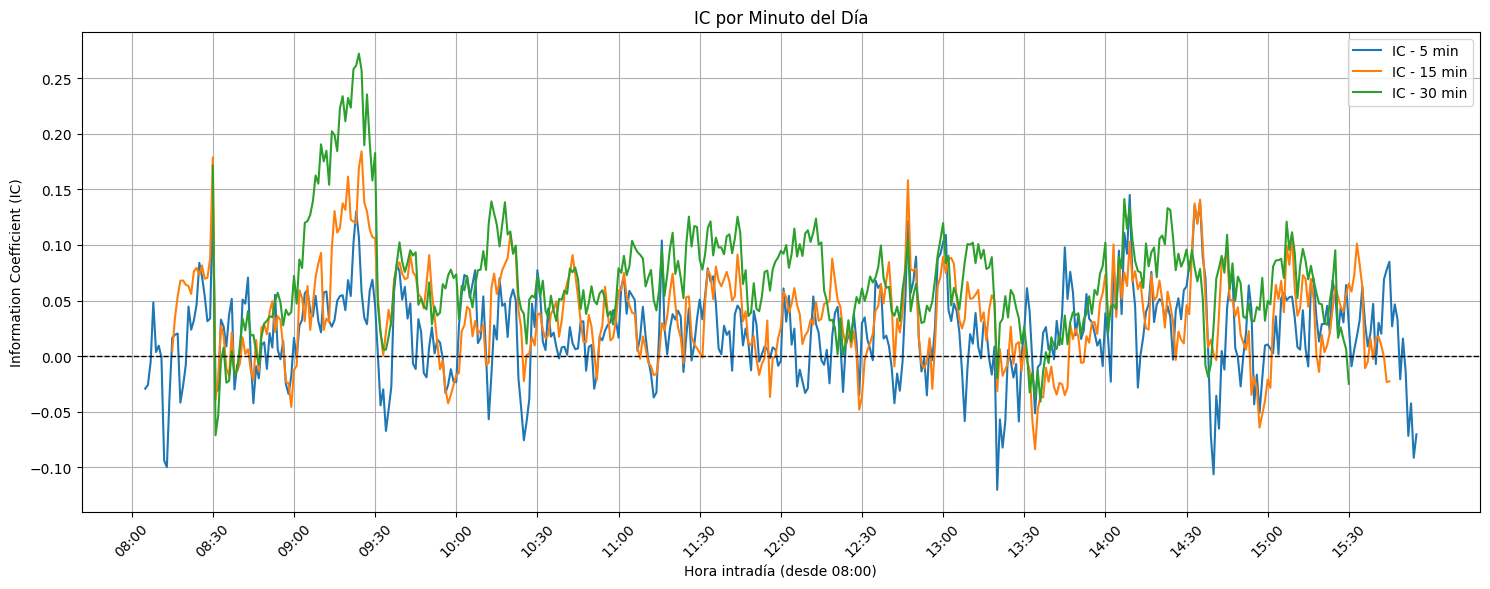

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 mejores ICs
Alpha Factor,,,,,
IC_rev_momentum_vol_30,-0.071254,08:31,0.271991,09:24,0.191103
IC_rev_momentum_vol_15,-0.083731,13:34,0.184074,09:25,0.124843
IC_rev_momentum_vol_5,-0.120246,13:20,0.144935,14:09,0.100975


In [116]:
#Hipotesis 3 - Replanteada
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='rev_mom_vol_z_5',
    factor_15='rev_mom_vol_z_15',
    factor_30='rev_mom_vol_z_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_rev_momentum_vol_5': ic_minute_5,
    'IC_rev_momentum_vol_15': ic_minute_15,
    'IC_rev_momentum_vol_30': ic_minute_30
})

# Ver los mejores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='best', top_n=30)

La reformulación del alpha factor de Hipótesis 3 (momentum × volumen, con signo invertido) mejoró sustancialmente su desempeño:

- El factor de 30 minutos es el más robusto: tiene el IC máximo más alto (0.272) y el mejor promedio más positivo (0.191), indicando mejor estabilidad y poder predictivo.

**Me conviene usar el factor con horizonte de 30 minutos. Es el que mejor combina señal positiva y menor ruido intradía.**


### 5.4. Añadir `rev_momentum_vol_30` al dataset:

In [ ]:
def add_reversion_vol_momentum_factor(df: pd.DataFrame,
                                      price_col: str = 'close',
                                      volume_col: str = 'volume',
                                      date_col: str = 'date',
                                      window: int = 30) -> pd.DataFrame:
    """
    Agrega una columna 'reversion_vol_momentum_factor' al DataFrame,
    que representa un alpha factor de reversión basado en:
    - Momentum a N minutos
    - Relación volumen actual / volumen promedio N
    - Z-score del factor por jornada
    - Inversión de signo para capturar reversión

    Parámetros:
    - df: DataFrame de entrada con columnas de precios, volumen y fechas
    - price_col: nombre de la columna de precios (default='close')
    - volume_col: nombre de la columna de volumen (default='volume')
    - date_col: nombre de la columna de fecha o jornada (default='date')
    - window: ventana en minutos para calcular momentum y volumen promedio (default=30)

    Retorna:
    - DataFrame con la columna 'reversion_vol_momentum_factor' añadida
    """
    df = df.copy()

    # 1. Calcular el momentum
    df['momentum'] = df.groupby(date_col)[price_col].transform(
        lambda x: np.log(x) - np.log(x.shift(window))
    )

    # 2. Calcular volumen promedio intradía (rolling por jornada)
    df['vol_avg'] = df.groupby(date_col)[volume_col].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    # 3. Relación volumen actual / volumen promedio
    df['vol_ratio'] = df[volume_col] / df['vol_avg']

    # 4. Alpha factor crudo: momentum × vol_ratio
    df['mom_vol'] = df['momentum'] * df['vol_ratio']

    # 5. Normalización diaria y reversión
    df['reversion_vol_momentum_factor'] = df.groupby(date_col)['mom_vol'].transform(
        lambda x: -(x - x.mean()) / x.std()
    )

    # 6. Limpieza opcional de columnas intermedias
    df.drop(columns=['momentum', 'vol_avg', 'vol_ratio', 'mom_vol'], inplace=True)

    return df

## 6. Hipotesis 4: Exhaustión del rango intradía

**"Si en la primera hora se alcanza un rango de precios muy amplio, el mercado tenderá a consolidar o revertir."**

Justificación técnica: En muchos activos, un rango amplio en la apertura (08:00 a 09:30 US/Eastern) refleja exceso de volatilidad temprana, frecuentemente impulsada por noticias o desequilibrios de oferta/demanda. Este impulso inicial puede agotarse, dando paso a consolidaciones o retrocesos.

Alpha Factor sugerido:
$$
\text{OpeningRange}_{day} = \text{max}(\text{high}_{08:00-09:30}) - \text{min}(\text{low}_{08:00-09:30})
$$

Y luego creamos un factor que mida cuán lejos está el precio actual respecto a ese rango:

$$
\text{Factor}_{t} =  \frac{\text{close}_t - \text{midpoint}_{opening range}}{\text{opening range width}}
$$

Donde:  
- $\text{midpoint}_t = (\text{high}_{open} + \text{low}_{open})/2  $

- Se aplica este factor al resto del día (después de las 09:30)

In [132]:
#Resetamos el dataset
mnq_intraday = reset_dataset()

In [144]:
#Hipotesis 4

def generar_opening_factor_z(df: pd.DataFrame, target_minutes=[5, 15, 30]) -> pd.DataFrame:
    df = df.copy()

    opening_start = "08:00:00"
    opening_end = "09:30:00"

    def get_opening_high(x):
        return x.between_time(opening_start, opening_end)['high'].max()

    def get_opening_low(x):
        return x.between_time(opening_start, opening_end)['low'].min()

    # Calcular métricas por día
    opening_range = df.groupby('date').apply(lambda x: pd.Series({
        'opening_high': get_opening_high(x),
        'opening_low': get_opening_low(x)
    }))

    opening_range['opening_range'] = opening_range['opening_high'] - opening_range['opening_low']
    opening_range['opening_midpoint'] = (opening_range['opening_high'] + opening_range['opening_low']) / 2

    # Evitar duplicación
    df = df.drop(columns=['opening_high', 'opening_low', 'opening_range', 'opening_midpoint'], errors='ignore')
    df = df.join(opening_range, on='date')

    df['after_opening'] = df.index >= df.index.normalize() + pd.Timedelta("09:30:00")

    df['opening_factor_raw'] = (
        (df['close'] - df['opening_midpoint']) / df['opening_range']
    ).where(df['after_opening'])

    for N in target_minutes:
        col_name = f"factor{N}"
        df[col_name] = df.groupby('date')['opening_factor_raw'].transform(
            lambda x: (x - x.mean()) / x.std()
        )

    return df

In [145]:
mnq_intraday =  generar_opening_factor_z (mnq_intraday, [5, 15, 30])
IC_hip4 = evaluar_alpha_factor(mnq_intraday, generar_opening_factor_z, factor_prefix="factor")
IC_hip4

,Mean IC
IC_5,-0.219089
IC_15,-0.362147
IC_30,-0.482980


#### Análisis de resultados

- A mayor ventana temporal, más fuerte es la correlación negativa entre tu alpha factor y los retornos futuros.

- Esto valida la hipótesis: cuando el rango de apertura es amplio y el precio se aleja de la media de apertura, tiende a revertirse, no a continuar. Es decir, el mercado se agota tras un fuerte movimiento inicial.


Conclusión:

El alpha factor basado en la hipótesis de exhaustión del rango intradía presenta un poder predictivo negativo creciente a medida que se extiende el horizonte temporal. Esto sugiere que cuando el precio se aleja significativamente del punto medio del rango de apertura, tiende a revertir su dirección en los próximos 15 a 30 minutos, lo que respalda la idea de agotamiento tras un inicio de sesión volátil.



### 6.1. Comportamiento de A.F. durante el día:

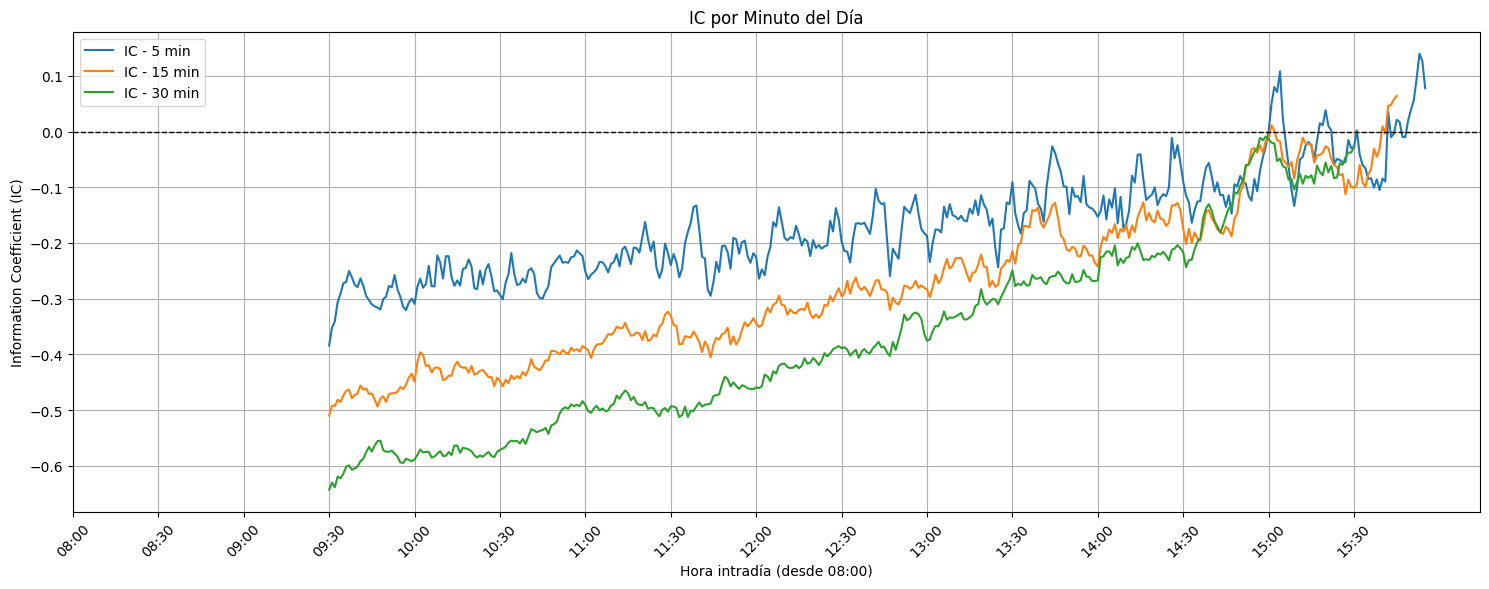

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
IC_exh_intraday_30,-0.643156,09:30,-0.009088,14:59,-0.597425
IC_exh_intraday_15,-0.509909,09:30,0.064062,15:45,-0.472997
IC_exh_intraday_5,-0.384073,09:30,0.139894,15:53,-0.306037


In [146]:
#Hipotesis 4
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='factor5',
    factor_15='factor15',
    factor_30='factor30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_exh_intraday_5': ic_minute_5,
    'IC_exh_intraday_15': ic_minute_15,
    'IC_exh_intraday_30': ic_minute_30
})

# Ver los mejores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)

#### Análisis de resultados

- Desde las 09:30 en adelante, los valores del IC son consistentemente negativos, especialmente en las primeras horas tras la apertura. Además, es la hora con IC más negativo en los tres horizontes. Esto es lógico, porque justo a esa hora se completa el rango de apertura (08:00 a 09:30), y el factor recién comienza a activarse.

- A medida que avanza el día, el IC tiende hacia cero o incluso se vuelve levemente positivo (al final de la jornada).

- Esto respalda la idea de que tras una apertura volátil, el mercado tiende a revertir en el corto y mediano plazo (5 a 30 min).

- Los valores extremadamente negativos reflejan que los desvíos fuertes desde el punto medio de apertura son señales de reversión posterior.

- El hecho de que el IC máximo esté cerca del cierre (15:45–15:53) y sea apenas positivo, muestra que el efecto se disipa al final del día, lo que también es consistente con el agotamiento temprano.

**Conclusión**

El alpha factor basado en la exhaustión del rango intradía muestra un fuerte poder predictivo negativo especialmente justo después de las 09:30, indicando que grandes movimientos iniciales tienden a ser seguidos por reversiones intradía. Este efecto es más marcado en horizontes de 15 a 30 minutos, y se disipa conforme avanza la jornada, validando empíricamente la hipótesis planteada.

Concluyo que el alpha `factor30` es el más adecuado para representar la hipótesis de exhaustión del rango intradía, ya que muestra la reversión más fuerte, consistente y aprovechable.


### 6.2. Añadir `factor30` al dataset:

In [147]:
#Resetamos el dataset
mnq_intraday = reset_dataset()

In [152]:
def add_opening_exhaustion_factor30(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Calcular métricas de apertura por jornada
    opening_start = "08:00:00"
    opening_end = "09:30:00"

    def get_opening_metrics(x):
        high = x.between_time(opening_start, opening_end)['high'].max()
        low = x.between_time(opening_start, opening_end)['low'].min()
        opening_range = high - low
        midpoint = (high + low) / 2
        return pd.Series({'range': opening_range, 'midpoint': midpoint})

    opening_df = df.groupby('date').apply(get_opening_metrics)

    # Calcular factor raw (solo después de 09:30)
    df = df.join(opening_df.rename(columns={'range': 'opening_range', 'midpoint': 'opening_midpoint'}), on='date')
    df['after_opening'] = df.index >= df.index.normalize() + pd.Timedelta("09:30:00")

    df['factor_raw'] = (
        (df['close'] - df['opening_midpoint']) / df['opening_range']
    ).where(df['after_opening'])

    # Calcular factor30 (z-score del raw, por día)
    df['factor30'] = df.groupby('date')['factor_raw'].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Limpiar columnas intermedias
    df = df.drop(columns=[
        'opening_range', 'opening_midpoint', 'after_opening', 'factor_raw'
    ])

    return df

In [153]:
mnq_intraday

,date,open,high,low,close,volume,target_return_5,target_return_15,target_return_30,factor30
datetime,,,,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,-0.000057,0.000143,0.000372,NaN
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,-0.000029,0.000086,0.000286,NaN
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000057,0.000200,0.000315,NaN
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,-0.000057,0.000000,0.000315,NaN
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000029,0.000000,0.000458,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN,NaN,NaN,-1.771542
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN,NaN,NaN,-1.681710
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN,NaN,NaN,-1.710456


In [154]:
mnq_intraday = add_opening_exhaustion_factor30(mnq_intraday)


In [155]:
mnq_intraday

,date,open,high,low,close,volume,target_return_5,target_return_15,target_return_30,factor30
datetime,,,,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,-0.000057,0.000143,0.000372,NaN
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,-0.000029,0.000086,0.000286,NaN
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000057,0.000200,0.000315,NaN
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,-0.000057,0.000000,0.000315,NaN
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000029,0.000000,0.000458,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN,NaN,NaN,-1.771542
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN,NaN,NaN,-1.681710
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN,NaN,NaN,-1.710456
